# Clusterização por Centis (K-Means 3D) — Patrimônio vs Dívidas

**Disciplina:** Aprendizado de Máquina Não Supervisionado  
**Projeto:** Clusterização em 3D com K-Means  
**Autor:** Anderson de Matos Guimarães  
**Data:** 2025-08-31

---

## 📌 Objetivo
Clusterizar **centis** (grupos de contribuintes) com base no **perfil patrimonial**:
- **Bens e Direitos — Imóveis [R$ milhões]**
- **Bens e Direitos — Financeiros [R$ milhões]**
- **Dívidas e Ônus [R$ milhões]**

Produzir:
1. Visualização 3D dos clusters.  
2. Perfil (médias) por cluster.  
3. Artefatos exportados (CSVs e HTML do gráfico).


## 1) Entendimento do Negócio

O dataset agrega **declarações de IRPF** por **centis de Renda Tributável Bruta (RTB)**.
- **Centil** = divisão da população ordenada por RTB em **100 partes** com a mesma quantidade de contribuintes.
- Unidade de análise: **(Ano-calendário, Ente Federativo, Centil)**.
- As variáveis patrimoniais são **somatórios por centil** (em milhões de R$).

**Perguntas de negócio:**
- Existem **perfis patrimoniais** distintos entre os centis?
- Como os **ativos (imóveis, financeiros)** se comparam às **dívidas** por cluster?
- O perfil varia entre **anos** ou **entes federativos**?


## 2) Dicionário de Dados (dataset limpo)

| Coluna | Descrição |
|---|---|
| **Ano-calendário** | Ano de referência das declarações. |
| **Ente Federativo** | Unidade geográfica (BRASIL ou UF). |
| **Centil** | Grupo da população (1 a 100), definido pela RTB. |
| **Quantidade de Contribuintes** | Número de contribuintes no centil. |
| **Bens e Direitos - Imóveis [R$ milhões]** | Total de imóveis declarados no centil. |
| **Bens e Direitos - Financeiros [R$ milhões]** | Total de ativos financeiros declarados no centil. |
| **Dívidas e Ônus [R$ milhões]** | Total de dívidas declaradas no centil. |

> Fonte: Receita Federal — *Distribuição de Renda por Centis* (metadados oficiais).


## 3) Setup


In [1]:
# Versões & Imports
import sys, platform, os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt  # (Elbow & silhouette)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

import plotly.express as px  # (3D interativo)

print('Python:', sys.version)
print('OS:', platform.platform())


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
OS: Windows-11-10.0.26100-SP0


## 4) Caminhos e Parâmetros


In [6]:
# === Caminhos e parâmetros ===
import os
from pathlib import Path

# arquivo limpo (3 variáveis) no seu repo:
DATA_PATH = Path("data/processed/distribuicao-renda-clean-3vars.csv")

if not DATA_PATH.exists():
    # tentativas alternativas, caso o notebook esteja em outra pasta
    candidates = [
        Path.cwd() / "data/processed/distribuicao-renda-clean-3vars.csv",
        Path.cwd().parent / "data/processed/distribuicao-renda-clean-3vars.csv",
        Path("data") / "distribuicao-renda-clean-3vars.csv",  # fallback se mover o arquivo p/ data/
    ]
    for c in candidates:
        if c.exists():
            DATA_PATH = c
            break

if not DATA_PATH.exists():
    raise FileNotFoundError(
        "Não encontrei o CSV. Verifique se o arquivo está em "
        "'data/processed/distribuicao-renda-clean-3vars.csv' ou ajuste DATA_PATH."
    )

EXPORT_DIR = "export/02_clusterizacao"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Parâmetros da amostragem e do K-Means
TARGET_N = 500
RANDOM_STATE = 42
K_RANGE = range(2, 9)
DEFAULT_K = 4

print("DATA_PATH ->", DATA_PATH.resolve())
print("EXPORT_DIR ->", Path(EXPORT_DIR).resolve())



DATA_PATH -> C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-clean-3vars.csv
EXPORT_DIR -> C:\QuartoSemestre\kmeans-3d-cluster\notebooks\export\02_clusterizacao


## 5) Carregamento e Visualização Inicial


In [7]:
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head(10))


Shape: (41867, 7)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,1864.5075,1576.3425,364.4525
1,2006,BRASIL,2,241.563,1864.5075,1576.3425,364.4525
2,2006,BRASIL,3,241.562,1864.5075,1576.3425,364.4525
3,2006,BRASIL,4,241.563,1864.5075,1576.3425,364.4525
4,2006,BRASIL,5,241.562,1864.5075,1576.3425,364.4525
5,2006,BRASIL,6,241.563,1864.5075,1576.3425,364.4525
6,2006,BRASIL,7,241.562,1864.5075,1576.3425,364.4525
7,2006,BRASIL,8,241.563,1864.5075,1576.3425,364.4525
8,2006,BRASIL,9,241.562,1864.5075,1576.3425,364.4525
9,2006,BRASIL,10,241.563,1864.5075,1576.3425,364.4525


## 6) Checagens Iniciais


In [8]:
# Tipos, nulos, intervalos
display(df.dtypes)
print('\nNulos por coluna:')
display(df.isna().sum())

print('\nAnos únicos:', sorted(df['Ano-calendário'].unique())[:10], '...')
print('Qtd anos:', df['Ano-calendário'].nunique())

print('\nEntes federativos (amostra):', df['Ente Federativo'].unique()[:10])
print('Qtd entes:', df['Ente Federativo'].nunique())

print('\nCentis (min..max):', df['Centil'].min(), '..', df['Centil'].max())
print('Qtd centis distintos:', df['Centil'].nunique())

# Chave primária lógica
dups = df.duplicated(subset=['Ano-calendário','Ente Federativo','Centil']).sum()
print('\nDuplicados por (ano, ente, centil):', dups)


Ano-calendário                                  int64
Ente Federativo                                object
Centil                                          int64
Quantidade de Contribuintes                   float64
Bens e Direitos - Imóveis [R$ milhões]        float64
Bens e Direitos - Financeiros [R$ milhões]    float64
Dívidas e Ônus [R$ milhões]                   float64
dtype: object


Nulos por coluna:


Ano-calendário                                0
Ente Federativo                               0
Centil                                        0
Quantidade de Contribuintes                   0
Bens e Direitos - Imóveis [R$ milhões]        0
Bens e Direitos - Financeiros [R$ milhões]    0
Dívidas e Ônus [R$ milhões]                   0
dtype: int64


Anos únicos: [np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015)] ...
Qtd anos: 15

Entes federativos (amostra): ['BRASIL' 'AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO']
Qtd entes: 28

Centis (min..max): 1 .. 100
Qtd centis distintos: 100

Duplicados por (ano, ente, centil): 0


## 7) Estratégia para ~500 entradas

Opções comuns:
1. **Amostra aleatória** (representativa para testes rápidos).
2. **Filtro por intervalo de anos** (ex.: 2006–2010) para manter consistência temporal.
3. **Estratificação** (mesmo número por ente federativo/ano).

Abaixo seguimos a **amostragem aleatória** com `random_state` fixo para reprodutibilidade.


## 8) Construção dos DataFrames de Clusterização


In [9]:
# Seleção de variáveis de clusterização (3 variáveis escolhidas)
VARS = [
    'Bens e Direitos - Imóveis [R$ milhões]',
    'Bens e Direitos - Financeiros [R$ milhões]',
    'Dívidas e Ônus [R$ milhões]'
]

meta_cols = ['Ano-calendário', 'Ente Federativo', 'Centil', 'Quantidade de Contribuintes']

df_cluster_full = df[meta_cols + VARS].copy()

# Amostra ~500
frac = min(1.0, TARGET_N / len(df_cluster_full))
df_cluster_500 = df_cluster_full.sample(frac=frac, random_state=RANDOM_STATE).reset_index(drop=True)

print('df_cluster_full:', df_cluster_full.shape)
print('df_cluster_500:', df_cluster_500.shape)

display(df_cluster_500.head())


df_cluster_full: (41867, 7)
df_cluster_500: (500, 7)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2012,MT,69,3.745,183.9100,154.0900,53.2400
1,2018,SP,84,97.711,1864.5075,1576.3425,364.4525
2,2006,PE,78,5.563,135.6800,126.6700,23.1400
3,2013,TO,86,1.357,104.5300,689.7300,35.0800
4,2010,PI,54,1.452,10.2000,8.6200,3.4300


## 9) Padronização (StandardScaler)


In [10]:
scaler = StandardScaler()

X_full = scaler.fit_transform(df_cluster_full[VARS])
X_500  = scaler.fit_transform(df_cluster_500[VARS])

print('X_full shape:', X_full.shape)
print('X_500  shape:', X_500.shape)


X_full shape: (41867, 3)
X_500  shape: (500, 3)


## 10) Seleção de *k* (Elbow + Silhouette)


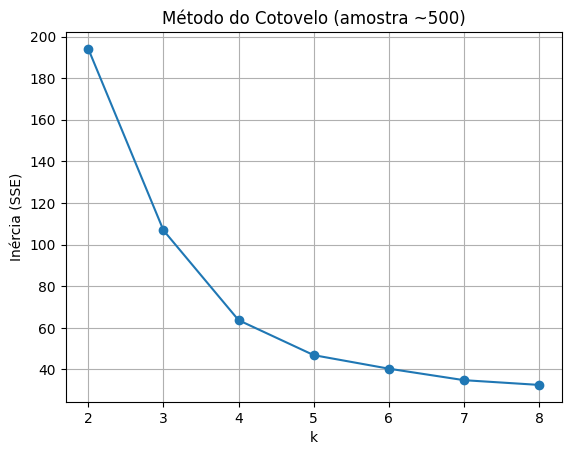

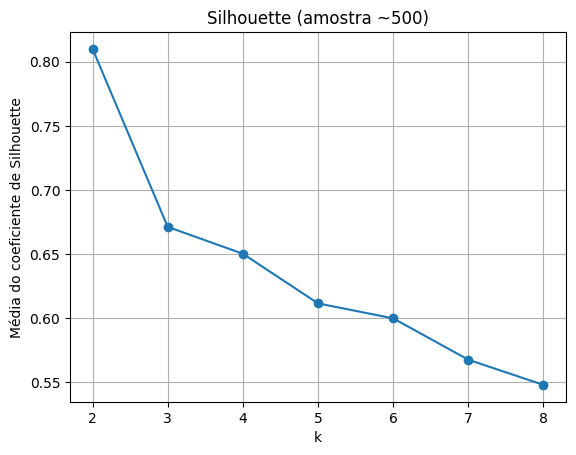

Melhor k por Silhouette (amostra): 2


In [11]:
inertias_500 = []
sil_500 = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    labels = km.fit_predict(X_500)
    inertias_500.append(km.inertia_)
    sil_500.append(silhouette_score(X_500, labels))

# Elbow
plt.figure()
plt.plot(list(K_RANGE), inertias_500, marker='o')
plt.title('Método do Cotovelo (amostra ~500)')
plt.xlabel('k')
plt.ylabel('Inércia (SSE)')
plt.grid(True)
plt.show()

# Silhouette
plt.figure()
plt.plot(list(K_RANGE), sil_500, marker='o')
plt.title('Silhouette (amostra ~500)')
plt.xlabel('k')
plt.ylabel('Média do coeficiente de Silhouette')
plt.grid(True)
plt.show()

best_k_sil = list(K_RANGE)[int(np.argmax(sil_500))]
print('Melhor k por Silhouette (amostra):', best_k_sil)


## 11) Treino do K-Means e Rotulagem


In [12]:
# Escolha de k: use `best_k_sil` ou fixe DEFAULT_K
k = best_k_sil  # ou: k = DEFAULT_K

kmeans_500 = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
df_cluster_500['cluster'] = kmeans_500.fit_predict(X_500)

centroids_scaled = kmeans_500.cluster_centers_
# Reverter para a escala original
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=VARS)
centroids_df.index.name = 'cluster'

display(df_cluster_500.head())
display(centroids_df)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões],cluster
0,2012,MT,69,3.745,183.9100,154.0900,53.2400,0
1,2018,SP,84,97.711,1864.5075,1576.3425,364.4525,1
2,2006,PE,78,5.563,135.6800,126.6700,23.1400,0
3,2013,TO,86,1.357,104.5300,689.7300,35.0800,0
4,2010,PI,54,1.452,10.2000,8.6200,3.4300,0


,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões]
cluster,,,
0,189.347455,159.815974,35.224649
1,1651.494565,1412.598457,318.207261


## 12) Visualização 3D Interativa


In [13]:
fig = px.scatter_3d(
    df_cluster_500,
    x='Bens e Direitos - Imóveis [R$ milhões]',
    y='Bens e Direitos - Financeiros [R$ milhões]',
    z='Dívidas e Ônus [R$ milhões]',
    color='cluster',
    hover_data=['Ano-calendário','Ente Federativo','Centil','Quantidade de Contribuintes'],
    title='Clusters (amostra ~500) — 3D'
)
fig.update_traces(marker=dict(size=4))
fig.show()

# Exportar HTML interativo
html_path = f"{EXPORT_DIR}/clusters_3d_amostra.html"
fig.write_html(html_path)
print('Gráfico salvo em:', html_path)


Gráfico salvo em: export/02_clusterizacao/clusters_3d_amostra.html


## 13) *Profiling* dos Clusters (Escala Original)


In [14]:
profile = (
    df_cluster_500
    .groupby('cluster')[VARS + ['Quantidade de Contribuintes']]
    .agg(['mean','median','min','max','count'])
)
profile


Bens e Direitos - Imóveis [R$ milhões]                                \
                                          mean     median     min        max   
cluster                                                                        
0                                   189.347455   105.2200    0.83  1072.4400   
1                                  1651.494565  1864.5075  398.00  1864.5075   

              Bens e Direitos - Financeiros [R$ milhões]                     \
        count                                       mean     median     min   
cluster                                                                       
0         385                                 159.815974    78.1900    0.23   
1         115                                1412.598457  1576.3425  418.47   

                         Dívidas e Ônus [R$ milhões]                    \
               max count                        mean    median     min   
cluster                                                                  
0        1209.4900   385                   35.224649   19.3100    0.00   
1        1576.3425   115                  318.207261  364.4525  166.06   

                        Quantidade de Contribuintes                          \
              max count                        mean  median    min      max   
cluster                                                                       
0        202.4500   385                   62.668265   4.165  1.118  969.000   
1        364.4525   115                   66.051739  25.434  2.176  304.985   

               
        count  
cluster        
0         385  
1         115

## 14) Exportação de Artefatos


In [15]:
# Exportar amostra rotulada e centróides
amostra_path = f"{EXPORT_DIR}/df_cluster_500_rotulado.csv"
centroids_path = f"{EXPORT_DIR}/kmeans_centroids_original.csv"

df_cluster_500.to_csv(amostra_path, index=False, encoding='utf-8')
centroids_df.to_csv(centroids_path, index=True, encoding='utf-8')

print('Amostra com rótulos  ->', amostra_path)
print('Centróides (original)->', centroids_path)


Amostra com rótulos  -> export/02_clusterizacao/df_cluster_500_rotulado.csv
Centróides (original)-> export/02_clusterizacao/kmeans_centroids_original.csv


## 15) Próximos Passos / Ideias

- Repetir o ajuste em **df_cluster_full** (sem amostragem) para ver estabilidade dos clusters.  
- Rodar K-Means por **ano** (clusterização anual) e comparar.  
- Explorar **padronização robusta** (RobustScaler) para lidar com *outliers*.  
- Criar **indicadores derivados** (ex.: Dívidas / (Imóveis + Financeiros)).  
- Validar variância intra/inter-cluster e **estabilidade** com *bootstrapping*.  
- Documentar **interpretação de cada cluster** (ex.: “alto ativo financeiro”, “endividamento elevado” etc.).


## 16) Reprodutibilidade


In [16]:
import importlib, pkgutil
mods = ['numpy','pandas','scikit-learn','matplotlib','plotly']
for m in mods:
    try:
        ver = importlib.import_module(m).__version__
    except Exception:
        ver = 'N/A'
    print(f"{m}: {ver}")


numpy: 2.3.2
pandas: 2.3.2
scikit-learn: N/A
matplotlib: 3.10.6
plotly: 6.3.0
